In [7]:
from __future__ import annotations

from qiskit import QuantumCircuit

three_qubit_bit_flip_encoding = QuantumCircuit(3)
three_qubit_bit_flip_encoding.cx(0, 1)
three_qubit_bit_flip_encoding.cx(0, 2)

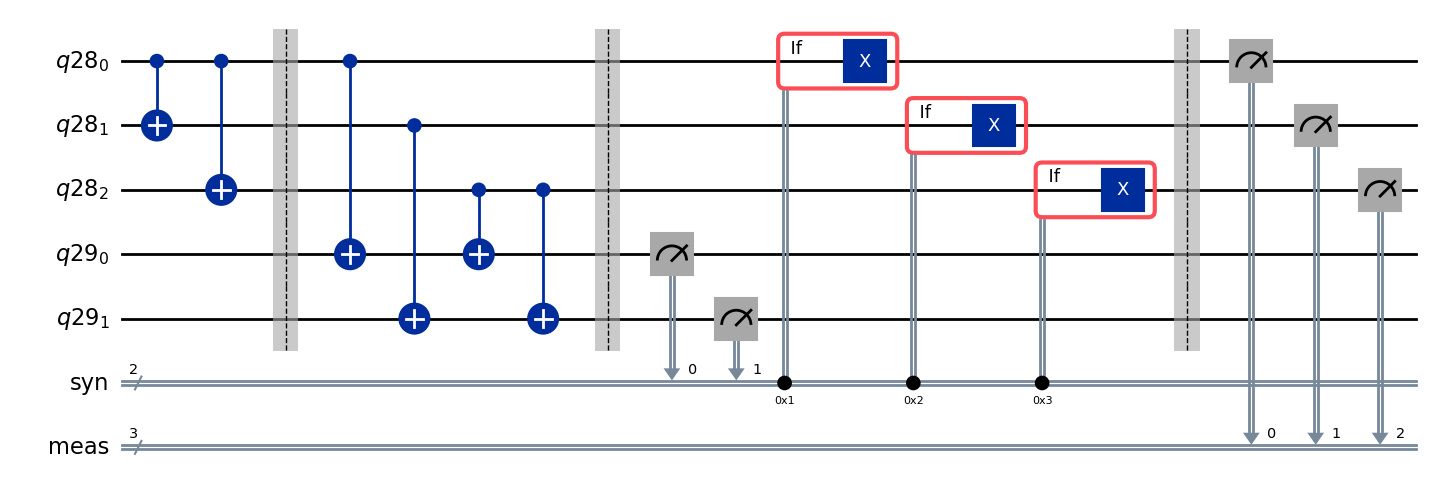

In [8]:
from qiskit import ClassicalRegister, QuantumCircuit, QuantumRegister


def get_3_qubit_bit_flip_correction_circuit(x_error_index: int | None = None) -> QuantumCircuit:
    logical_qubit = QuantumRegister(3)
    error_ancillas = QuantumRegister(2)
    syndrome_measurements = ClassicalRegister(2, "syn")
    final_measurement = ClassicalRegister(3, "meas")
    out = QuantumCircuit(logical_qubit, error_ancillas, syndrome_measurements, final_measurement)
    # Encoding
    out.compose(three_qubit_bit_flip_encoding, qubits=(0, 1, 2), inplace=True)
    out.barrier()
    # Test error
    if x_error_index is not None:
        out.x(logical_qubit[x_error_index])
    # Syndrome detection
    out.cx(logical_qubit[0], error_ancillas[0])
    out.cx(logical_qubit[2], error_ancillas[0])
    out.cx(logical_qubit[1], error_ancillas[1])
    out.cx(logical_qubit[2], error_ancillas[1])
    out.barrier()
    out.measure(error_ancillas, syndrome_measurements)
    # Syndrome correction
    with out.if_test((syndrome_measurements, 0b01)):
        out.x(logical_qubit[0])
    with out.if_test((syndrome_measurements, 0b10)):
        out.x(logical_qubit[1])
    with out.if_test((syndrome_measurements, 0b11)):
        out.x(logical_qubit[2])
    out.barrier()
    # Final measurement
    out.measure(logical_qubit, final_measurement)
    return out


_ = get_3_qubit_bit_flip_correction_circuit().draw("mpl")

In [9]:
from typing import TYPE_CHECKING

from qiskit import transpile
from qiskit_aer import AerSimulator

if TYPE_CHECKING:
    from collections.abc import Callable

simulator = AerSimulator()


def get_circuit_outputs(circuit: QuantumCircuit) -> dict[str, int]:
    compiled_circuit = transpile(circuit, simulator)
    result = simulator.run(compiled_circuit, shots=1024).result()
    return result.get_counts()


def get_desired_measurement_result(num_logical_qubits: int, num_syndrome_qubits: int, x_error_index: int) -> str:
    return ("0" * num_logical_qubits) + f" {x_error_index + 1:0{num_syndrome_qubits}b}"


def test_circuit_generation_function(
    circ_gen_func: Callable[[int], QuantumCircuit], num_logical_qubits: int, num_syndrome_qubits: int
) -> None:
    for i in range(num_logical_qubits):
        desired_measurement = get_desired_measurement_result(num_logical_qubits, num_syndrome_qubits, i)
        measurement_counts = get_circuit_outputs(circ_gen_func(i))
        assert desired_measurement in measurement_counts
        assert measurement_counts[desired_measurement] == 1024
        print(f"Correct result for X error on qubit {i}: {desired_measurement}")

In [10]:
test_circuit_generation_function(get_3_qubit_bit_flip_correction_circuit, 3, 2)

Correct result for X error on qubit 0: 000 01
Correct result for X error on qubit 1: 000 10
Correct result for X error on qubit 2: 000 11


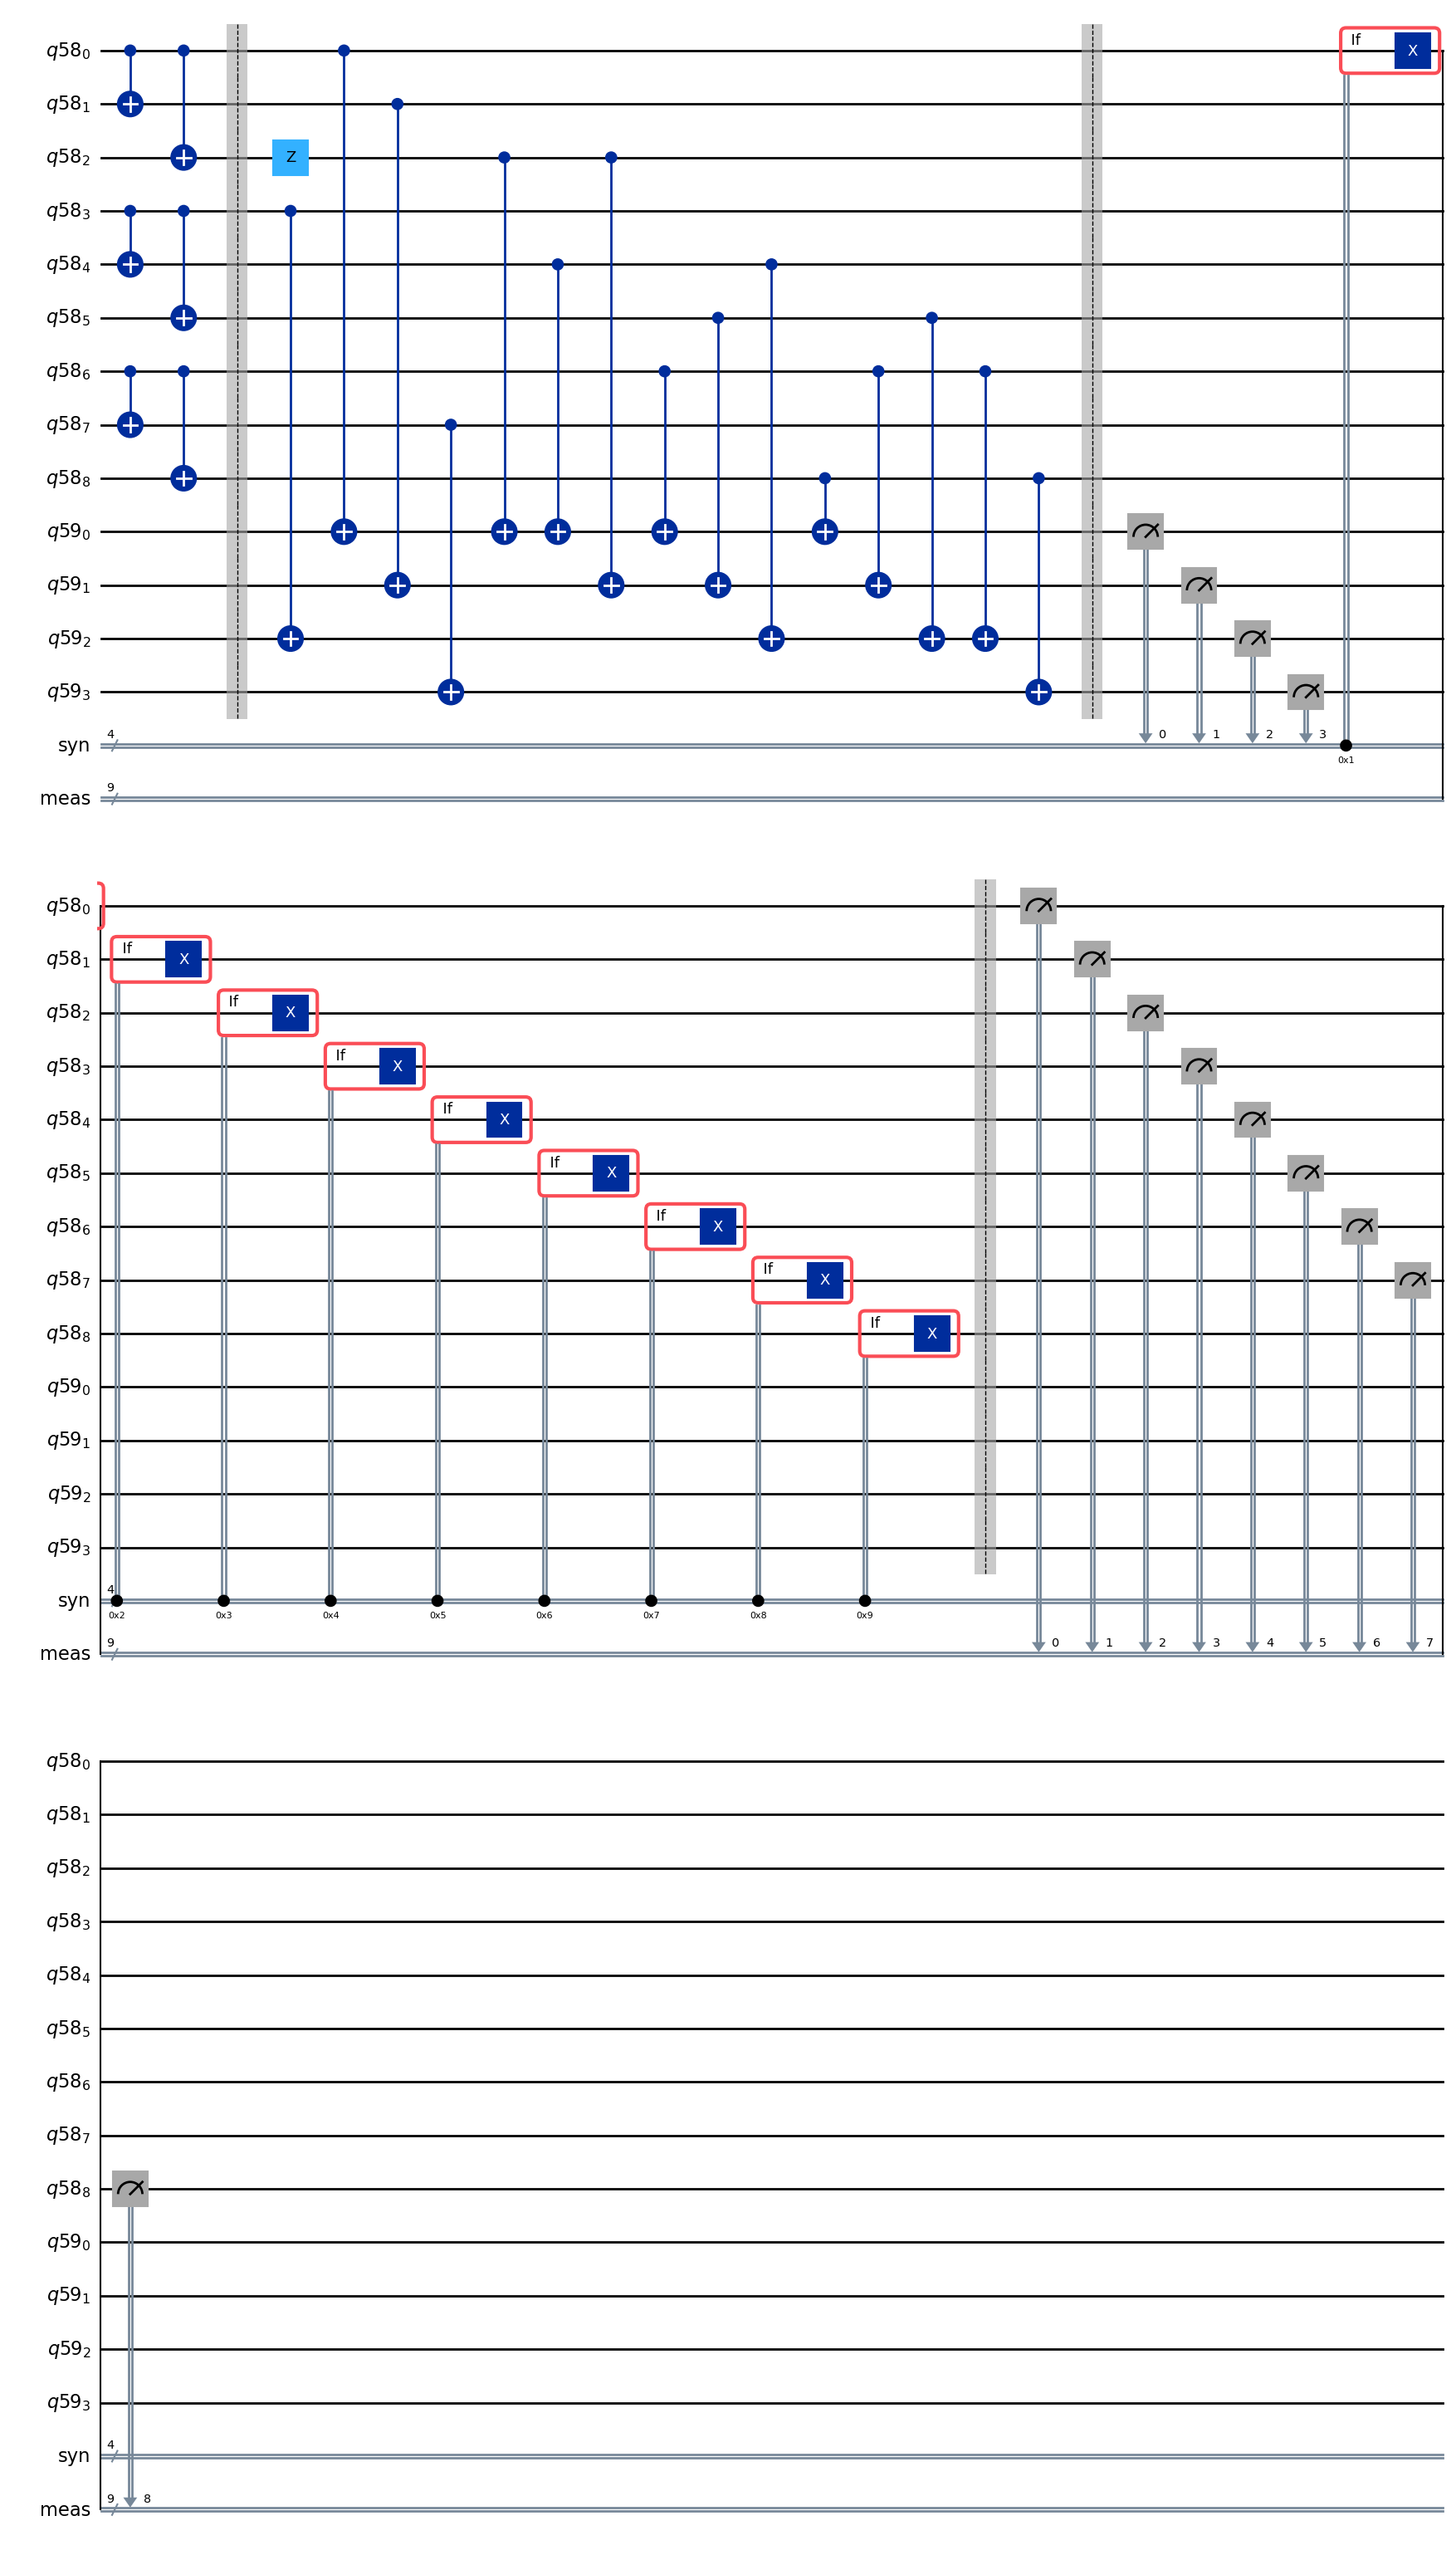

In [15]:
def get_9_qubit_bit_flip_correction_circuit(x_error_index: int | None = None) -> QuantumCircuit:
    logical_qubit = QuantumRegister(9)
    error_ancillas = QuantumRegister(4)
    syndrome_measurements = ClassicalRegister(4, "syn")
    final_measurement = ClassicalRegister(9, "meas")
    out = QuantumCircuit(logical_qubit, error_ancillas, syndrome_measurements, final_measurement)
    # Encoding
    out.compose(three_qubit_bit_flip_encoding, qubits=(0, 1, 2), inplace=True)
    out.compose(three_qubit_bit_flip_encoding, qubits=(3, 4, 5), inplace=True)
    out.compose(three_qubit_bit_flip_encoding, qubits=(6, 7, 8), inplace=True)
    out.barrier()
    # Test error
    if x_error_index is not None:
        out.x(logical_qubit[x_error_index])
    # Syndrome detection
    # qubit syndrome
    # --------------
    # None  0000
    # 0     0001
    # 1     0010
    # 2     0011
    # 3     0100
    # 4     0101
    # 5     0110
    # 6     0111
    # 7     1000
    # 8     1001
    for q in [0, 2, 4, 6, 8]:
        out.cx(logical_qubit[q], error_ancillas[0])

    for q in [1, 2, 5, 6]:
        out.cx(logical_qubit[q], error_ancillas[1])

    for q in [3, 4, 5, 6]:
        out.cx(logical_qubit[q], error_ancillas[2])

    for q in [7, 8]:
        out.cx(logical_qubit[q], error_ancillas[3])

    out.barrier()
    out.measure(error_ancillas, syndrome_measurements)
    # Syndrome correction
    for i in range(9):
        with out.if_test((syndrome_measurements, i + 1)):
            out.x(logical_qubit[i])
    out.barrier()
    # Final measurement
    out.measure(logical_qubit, final_measurement)
    return out


_ = get_9_qubit_bit_flip_correction_circuit().draw("mpl")

In [16]:
test_circuit_generation_function(get_9_qubit_bit_flip_correction_circuit, 9, 4)

Correct result for X error on qubit 0: 000000000 0001
Correct result for X error on qubit 1: 000000000 0010
Correct result for X error on qubit 2: 000000000 0011
Correct result for X error on qubit 3: 000000000 0100
Correct result for X error on qubit 4: 000000000 0101
Correct result for X error on qubit 5: 000000000 0110
Correct result for X error on qubit 6: 000000000 0111
Correct result for X error on qubit 7: 000000000 1000
Correct result for X error on qubit 8: 000000000 1001


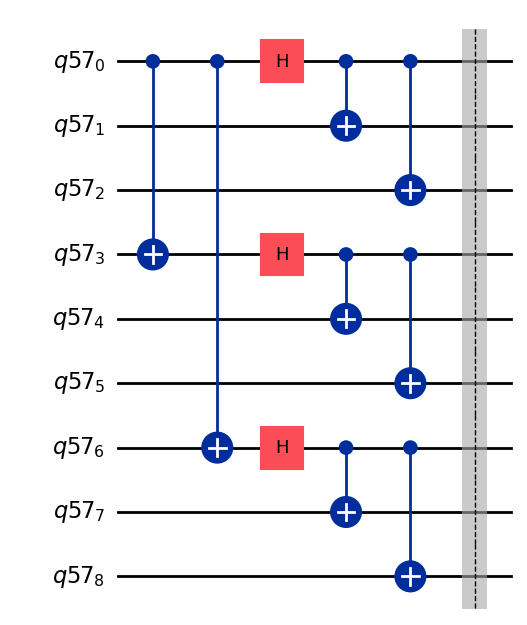

In [14]:
# TODO
# - complete function
#   - decide which type of z syndrome measurement to use?
#     - 9 Hadamards + 12 CNOTS, or
#     - complete decoding and re-encoding
# - decide how to test output
#   - measure in Hadamard basis?
#   - what about testing both z and x together? Bell basis?

def get_shors_9_qubit_code_circuit(x_error_index: int | None = None) -> QuantumCircuit:
    logical_qubit = QuantumRegister(9)
    # error_ancillas = QuantumRegister(4)
    # syndrome_measurements = ClassicalRegister(4, "syn")
    # final_measurement = ClassicalRegister(9, "meas")
    # out = QuantumCircuit(logical_qubit, error_ancillas, syndrome_measurements, final_measurement)
    out = QuantumCircuit(logical_qubit)
    # Encoding
    out.cx(0, 3)
    out.cx(0, 6)
    out.h(0)
    out.h(3)
    out.h(6)
    out.compose(three_qubit_bit_flip_encoding, qubits=(0, 1, 2), inplace=True)
    out.compose(three_qubit_bit_flip_encoding, qubits=(3, 4, 5), inplace=True)
    out.compose(three_qubit_bit_flip_encoding, qubits=(6, 7, 8), inplace=True)
    out.barrier()
    # # Test error
    # if x_error_index is not None:
    #     out.x(logical_qubit[x_error_index])
    # # Syndrome detection
    # # qubit syndrome
    # # --------------
    # # None  0000
    # # 0     0001
    # # 1     0010
    # # 2     0011
    # # 3     0100
    # # 4     0101
    # # 5     0110
    # # 6     0111
    # # 7     1000
    # # 8     1001
    # for q in [0, 2, 4, 6, 8]:
    #     out.cx(logical_qubit[q], error_ancillas[0])
    #
    # for q in [1, 2, 5, 6]:
    #     out.cx(logical_qubit[q], error_ancillas[1])
    #
    # for q in [3, 4, 5, 6]:
    #     out.cx(logical_qubit[q], error_ancillas[2])
    #
    # for q in [7, 8]:
    #     out.cx(logical_qubit[q], error_ancillas[3])
    #
    # out.barrier()
    # out.measure(error_ancillas, syndrome_measurements)
    # # Syndrome correction
    # for i in range(9):
    #     with out.if_test((syndrome_measurements, i + 1)):
    #         out.x(logical_qubit[i])
    # out.barrier()
    # # Final measurement
    # out.measure(logical_qubit, final_measurement)
    return out


_ = get_shors_9_qubit_code_circuit().draw("mpl")